# Breast Cancer Diagnosis

Let's examine this data set from the University of Wisconsin Hospitals on breast cancer diagnosis and model it as a classification problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('white')

In [2]:
full_df = pd.read_csv('breast-cancer-wisconsin.data', 
                      names=['id','clumpthickness','cellsize','cellshape','adhesion','epithelialsize',
                             'barenuclei','chromatin','nucleoli','mitosis','class']
                     ) 
full_df['class'] = full_df['class'].replace({2:0, 4:1})
full_df['barenuclei'] = pd.to_numeric(full_df['barenuclei'], errors='coerce')
full_df = full_df.dropna()
full_df.shape

(683, 11)

## Exploring the Data

First, let's take a look at the data set. 

In [3]:
full_df.head()

,id,clumpthickness,cellsize,cellshape,adhesion,epithelialsize,barenuclei,chromatin,nucleoli,mitosis,class
0,1000025,5,1,1,1,2,1.0,3,1,1,0
1,1002945,5,4,4,5,7,10.0,3,2,1,0
2,1015425,3,1,1,1,2,2.0,3,1,1,0
3,1016277,6,8,8,1,3,4.0,3,7,1,0
4,1017023,4,1,1,3,2,1.0,3,1,1,0


In [4]:
full_df.drop(['id'], axis=1, inplace=True)

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


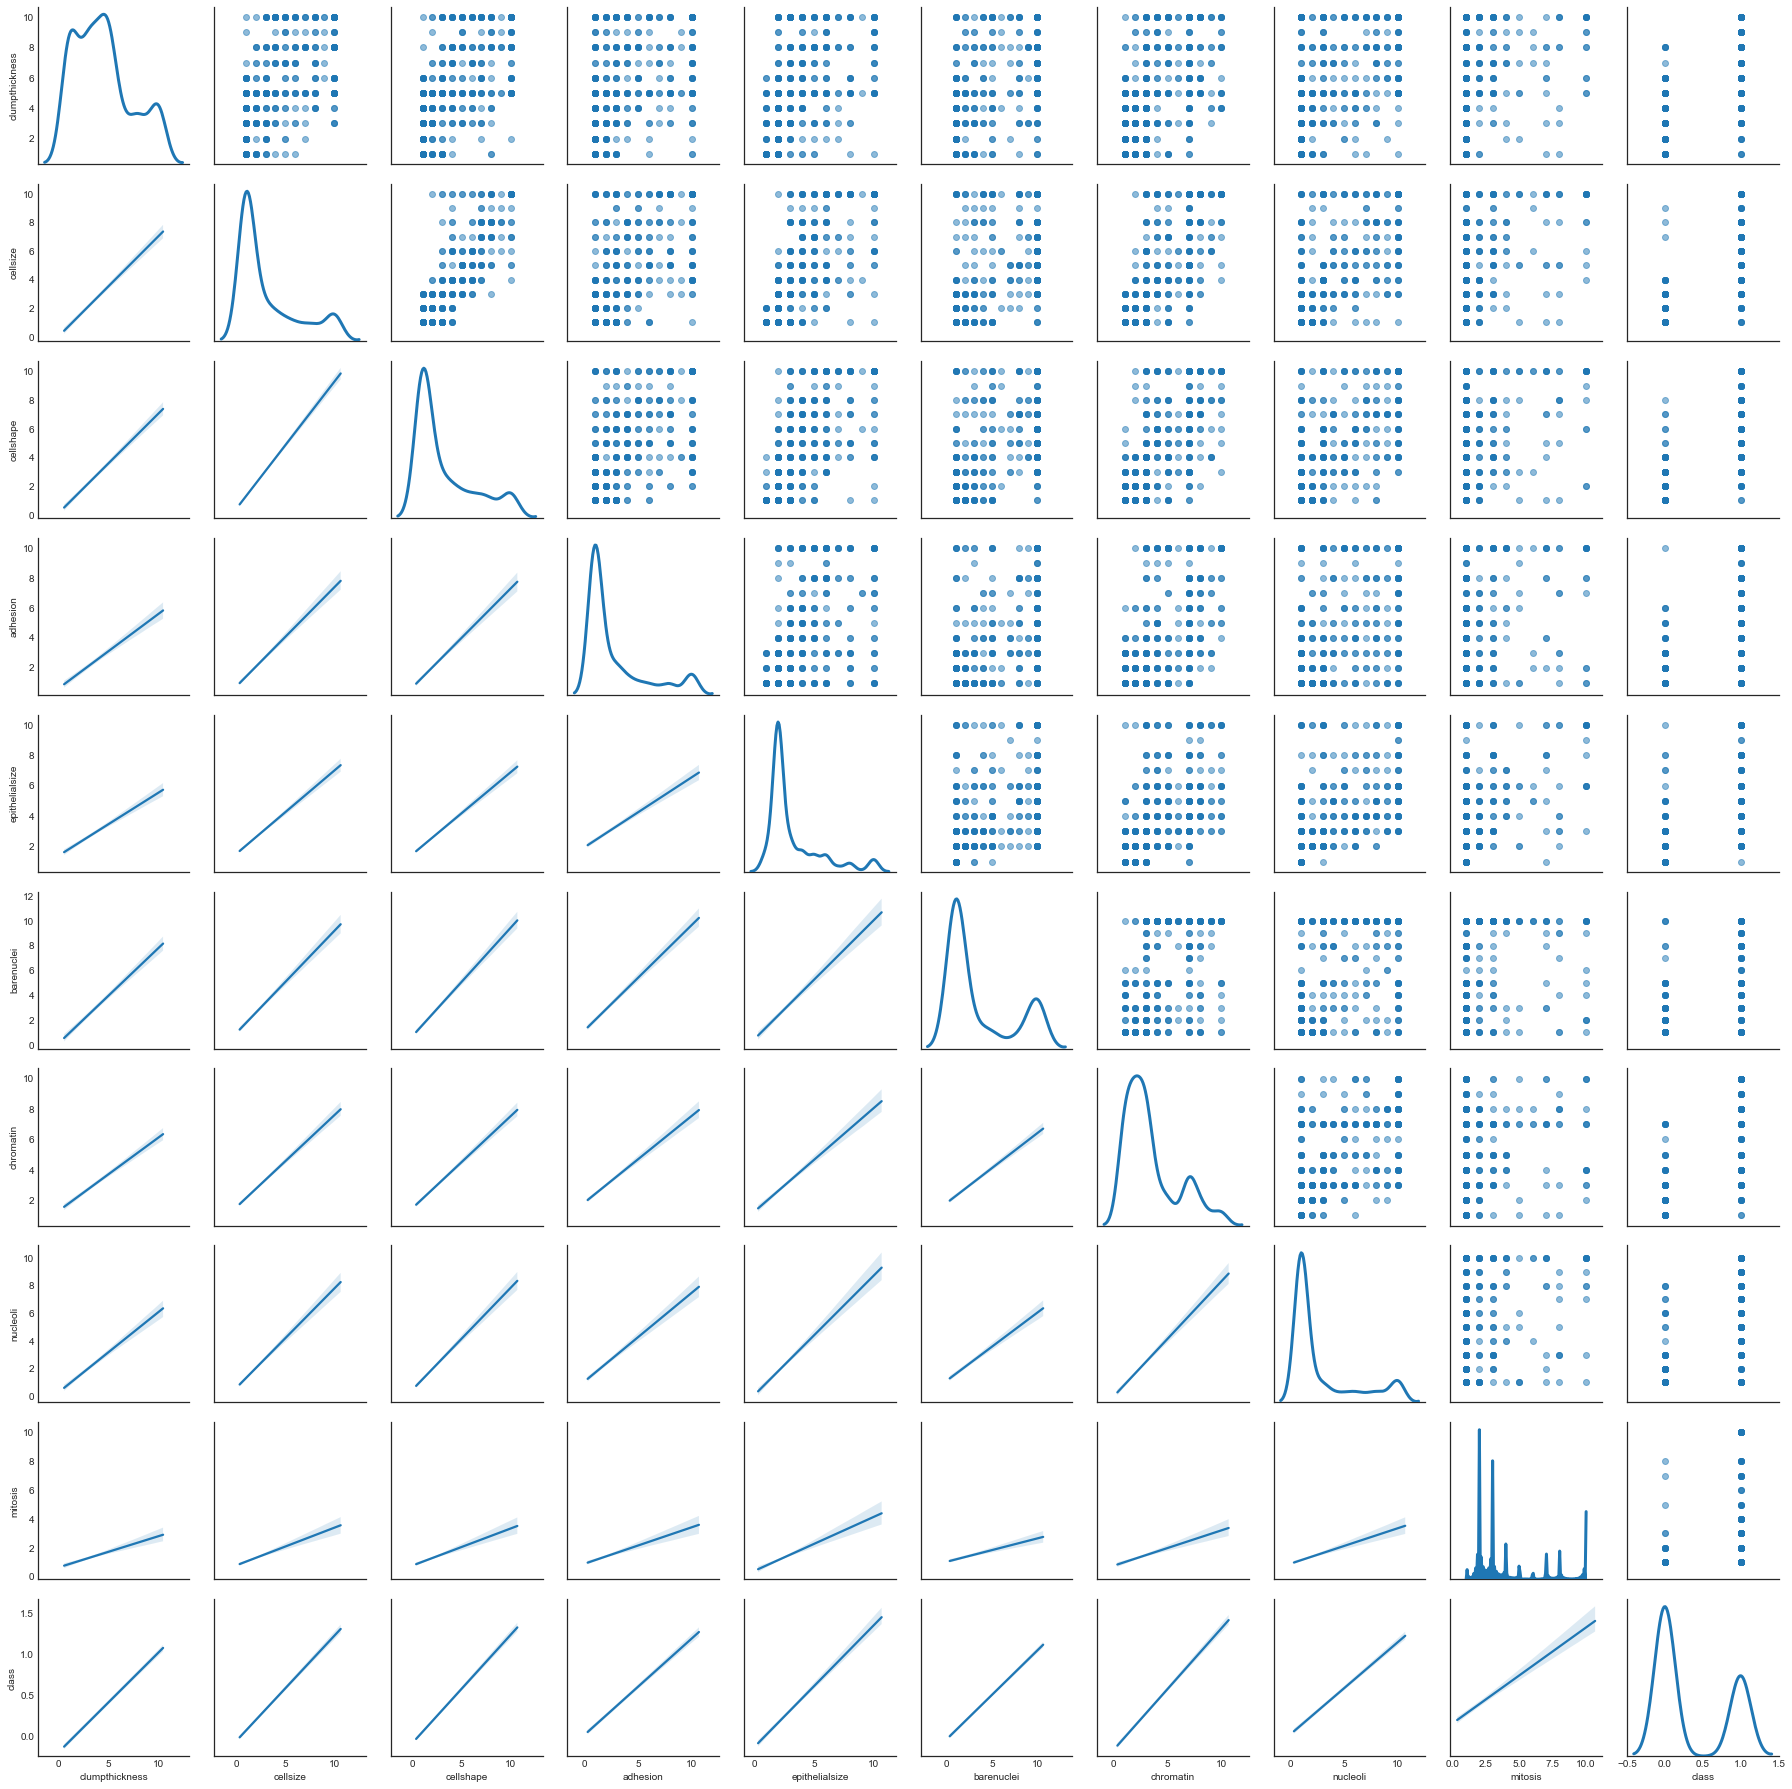

In [5]:
g = sns.PairGrid(full_df, diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)

plt.show()

We've got a class imbalance in our outcome variable -- half as many positive results as negative. We'll resample to balance those classes.

In [6]:
full_df.isnull().sum()

clumpthickness    0
cellsize          0
cellshape         0
adhesion          0
epithelialsize    0
barenuclei        0
chromatin         0
nucleoli          0
mitosis           0
class             0
dtype: int64

This data is already nice and clean! Let's do some feature selection and get to modeling.

In [7]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.utils import resample
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, auc, precision_recall_curve, average_precision_score

First, let's just run a quick random forest to see where we're starting.

In [8]:
data_train, data_test = train_test_split(full_df, test_size=0.3)
X_train = data_train.loc[:, ~data_train.columns.isin(['class'])]
X_test = data_test.loc[:, ~data_test.columns.isin(['class'])]
Y_train = data_train['class']
Y_test = data_test['class']

X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)
print(rfc.score(X_test, Y_test))
print(average_precision_score(Y_test, Y_pred))
print(confusion_matrix(Y_test, Y_pred))

0.980487804878
0.96068866571
[[137   0]
 [  4  64]]


Wow. Well, we're doing great already. I guess we can run through the rest of the steps to see if anything else can compete with random forest.

## Feature Selection

We've only got 9 features, so let's engineer some more before we start paring them down.

In [9]:
for column in full_df.columns[~full_df.columns.isin(['class'])]:
    full_df[column + '_sqrt'] = np.sqrt(full_df[column])
    full_df[column + '_squared'] = full_df[column] ** 2

In [10]:
full_df.columns

Index(['clumpthickness', 'cellsize', 'cellshape', 'adhesion', 'epithelialsize',
       'barenuclei', 'chromatin', 'nucleoli', 'mitosis', 'class',
       'clumpthickness_sqrt', 'clumpthickness_squared', 'cellsize_sqrt',
       'cellsize_squared', 'cellshape_sqrt', 'cellshape_squared',
       'adhesion_sqrt', 'adhesion_squared', 'epithelialsize_sqrt',
       'epithelialsize_squared', 'barenuclei_sqrt', 'barenuclei_squared',
       'chromatin_sqrt', 'chromatin_squared', 'nucleoli_sqrt',
       'nucleoli_squared', 'mitosis_sqrt', 'mitosis_squared'],
      dtype='object')

Now let's see how they perform. We'll try RFE, Select K Best, PCA, and Random Forest. But first let's resample our classes.

In [11]:
data_train, data_test = train_test_split(full_df, test_size=0.3)

data_train_pos = data_train[data_train['class']==1]
data_train_neg = data_train[data_train['class']==0]
print(data_train_pos.shape, data_train_neg.shape)

data_train_pos = resample(data_train_pos, n_samples=len(data_train_neg))
print(data_train_pos.shape, data_train_neg.shape)

data_train = pd.concat([data_train_pos, data_train_neg]).sample(frac=1)

X_train = data_train.loc[:, ~data_train.columns.isin(['class'])]
X_test = data_test.loc[:, ~data_test.columns.isin(['class'])]
Y_train = data_train['class']
Y_test = data_test['class']

(167, 28) (311, 28)
(311, 28) (311, 28)


We'll start with random forest to get a sense of how many features we should keep.

In [12]:
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)
print(rfc.score(X_test, Y_test))
print(average_precision_score(Y_test, Y_pred))
print(confusion_matrix(Y_test, Y_pred))

0.956097560976
0.896300813008
[[127   6]
 [  3  69]]


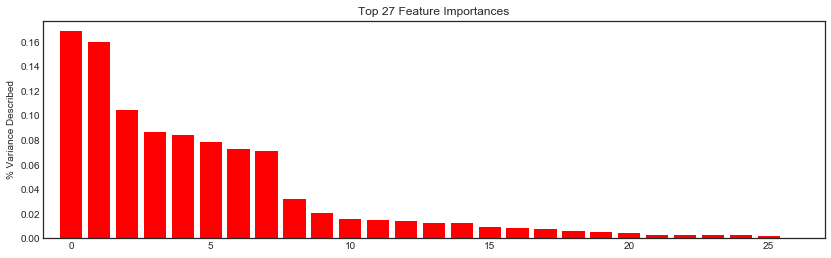

In [13]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[:1000]

# Plot the feature importances of the forest
plt.figure(figsize=(14, 4))
plt.title("Top {} Feature Importances".format(len(top_indices)))
plt.bar(range(len(top_indices)), importances[top_indices],
       color="r", align="center")
plt.xlim([-1, len(top_indices)])
plt.ylabel('% Variance Described')
plt.show()

In [14]:
for n_idx in [4, 8, 12, 16, 20, 24]:
    print('Variance explained with {} features: {}'.format(n_idx, importances[indices[:n_idx]].sum()))
print('Total Features: ' + str(len(indices)))

Variance explained with 4 features: 0.5188167946628645
Variance explained with 8 features: 0.825065169906501
Variance explained with 12 features: 0.908773570607677
Variance explained with 16 features: 0.9563345463222551
Variance explained with 20 features: 0.9831526823315104
Variance explained with 24 features: 0.9955019587257004
Total Features: 27


In [15]:
n_indices = 16
X_train_rfc = X_train.loc[:, X_train.columns[indices[:n_indices]]]
X_test_rfc = X_test.loc[:, X_train.columns[indices[:n_indices]]]
print(X_train_rfc.shape, X_test_rfc.shape)

(622, 16) (205, 16)


In [17]:
rfe = RFE(estimator=rfc, n_features_to_select=16)
rfe.fit(X_train, Y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [18]:
skb = SelectKBest(k=16)
skb.fit(X_train, Y_train)
X_train_skb = skb.transform(X_train)
X_test_skb = skb.transform(X_test)

In [19]:
pca = PCA(n_components=16)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Let's use a less-good model to test these out, since random forest is getting it pretty much exactly right.

In [20]:
lgr = LogisticRegression()
lgr.fit(X_train, Y_train)
Y_pred = lgr.predict(X_test)
print('Without Feature Selection:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

Without Feature Selection:
[[127   6]
 [  2  70]]
0.905223933818


In [21]:
lgr.fit(X_train_rfc, Y_train)
Y_pred = lgr.predict(X_test_rfc)
print('Random Forest Feature Selection:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

Random Forest Feature Selection:
[[126   7]
 [  3  69]]
0.884699935815


In [22]:
lgr.fit(X_train_rfe, Y_train)
Y_pred = lgr.predict(X_test_rfe)
print('RFE Feature Selection:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

RFE Feature Selection:
[[126   7]
 [  3  69]]
0.884699935815


In [23]:
lgr.fit(X_train_skb, Y_train)
Y_pred = lgr.predict(X_test_skb)
print('Select K Best Feature Selection:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

Select K Best Feature Selection:
[[127   6]
 [  3  69]]
0.896300813008


In [24]:
lgr.fit(X_train_pca, Y_train)
Y_pred = lgr.predict(X_test_pca)
print('PCA Feature Decomposition:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

PCA Feature Decomposition:
[[127   6]
 [  2  70]]
0.905223933818


They're all about the same, and when I run them multiple times they're indistinguishable from each other. Because we have so few features to start with, let's just use them all.

## Model Selection

Let's see how all our different models compare, and if anything can do quite as well as random forest. RFE did the best, so we'll use that.

In [29]:
lgr = LogisticRegression()
lgr.fit(X_train, Y_train)
Y_pred = lgr.predict(X_test)
print('Logistic Regression:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))
print(lgr.score(X_test, Y_test))

Logistic Regression:
[[127   6]
 [  2  70]]
0.905223933818
0.960975609756


In [30]:
bnb = BernoulliNB()
bnb.fit(X_train, Y_train)
Y_pred = bnb.predict(X_test)
print('Naive Bayes:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))
print(bnb.score(X_test, Y_test))

Naive Bayes:
[[133   0]
 [ 72   0]]
0.351219512195
0.648780487805


In [31]:
knc = KNeighborsClassifier(n_neighbors=3)
knc.fit(X_train, Y_train)
Y_pred = knc.predict(X_test)
print('KNN:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))
print(knc.score(X_test, Y_test))

KNN:
[[126   7]
 [  1  71]]
0.902492008894
0.960975609756


In [32]:
svc = SVC(C=10)
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
print('SVC:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))
print(svc.score(X_test, Y_test))

SVC:
[[105  28]
 [  0  72]]
0.72
0.863414634146


In [33]:
dtc_params = {'max_depth':[4, 12, 32, None],
              'max_features':[2, 8, 'sqrt', None],
              'min_samples_split':[2, 4]}
dtc_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dtc_params)
dtc_grid.fit(X_train_rfe, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 12, 32, None], 'max_features': [2, 8, 'sqrt', None], 'min_samples_split': [2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [34]:
print(dtc_grid.best_score_)
print(dtc_grid.best_params_)

0.979099678457
{'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 2}


In [37]:
dtc = DecisionTreeClassifier(max_depth=4, max_features='sqrt', min_samples_split=2)
dtc.fit(X_train, Y_train)
Y_pred = dtc.predict(X_test)
print('Decision Tree:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))
print(dtc.score(X_test, Y_test))

Decision Tree:
[[125   8]
 [  4  68]]
0.864541434888
0.941463414634


In [38]:
rfc_params = {'max_depth':[4, 8, 32, None],
              'n_estimators':[8, 24, 64],
              'min_samples_split':[2, 8],
              'max_features':[2, 8, 'sqrt', None]}
rfc_grid = GridSearchCV(RandomForestClassifier(), param_grid=rfc_params)
rfc_grid.fit(X_train_rfe, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 8, 32, None], 'n_estimators': [8, 24, 64], 'min_samples_split': [2, 8], 'max_features': [2, 8, 'sqrt', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [39]:
print(rfc_grid.best_score_)
print(rfc_grid.best_params_)

0.985530546624
{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 24}


In [51]:
rfc = RandomForestClassifier(max_depth=None, max_features=None, min_samples_split=8, n_estimators=24)
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)
print('Random Forest:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))
print(rfc.score(X_test, Y_test))

Random Forest:
[[127   6]
 [  2  70]]
0.905223933818
0.960975609756


In [52]:
gbc_params = {'max_depth':[12, 32],
              'n_estimators':[50, 100],
              'learning_rate':[0.1, 0.3]}
gbc_grid = GridSearchCV(GradientBoostingClassifier(), param_grid=gbc_params)
gbc_grid.fit(X_train_rfe, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [12, 32], 'n_estimators': [50, 100], 'learning_rate': [0.1, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [53]:
print(gbc_grid.best_score_)
print(gbc_grid.best_params_)

0.966237942122
{'learning_rate': 0.3, 'max_depth': 32, 'n_estimators': 50}


In [54]:
gbc = GradientBoostingClassifier(learning_rate=0.3, max_depth=12, n_estimators=50)
gbc.fit(X_train, Y_train)
Y_pred = gbc.predict(X_test)
print('Gradient Boosting:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))
print(gbc.score(X_test, Y_test))

Gradient Boosting:
[[127   6]
 [  4  68]]
0.88738006299
0.951219512195


Nothing is really doing any better than our initial trial run. And it would be hard to do better in the first place! Also, all the tuning with gridsearch didn't yield a better result than running with defaults.

In [56]:
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)
print('Full engineered feature set random forest:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))
print(rfc.score(X_test, Y_test))

Full engineered feature set random forest:
[[128   5]
 [  2  70]]
0.917163504968
0.965853658537


## Conclusion

The big conclusion here is that this classification problem is easy but the data set is too small. We have fewer than 700 examples, and even so we're able to score over 0.96 accuracy. Random forest did work best, but all the models except Naive Bayes and SVC did quite well. This is a high-stakes prediction to make -- any false positive or worse, false negative, may result in substantial personal harm. Yet it is remarkable that the model performs as well as it does. Even though the correlation is not immediately clear from looking at the variable interactions, there is still a fairly clear-cut distinction between malignant and non-malignant tumors in the data. The next step here is certain to acquire more data to make the model more robust. 